## Notebook for models without the decades 1960 and 1970

In [1]:
import psycopg2 as pg
import pandas as pd

# We are also going to do some basic viz
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import roc_curve , roc_auc_score
from sklearn.model_selection import GridSearchCV
import pickle

#Import all the models that I will use
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
import xgboost as xgb

In [2]:
connection_args = {
    'host': 'localhost', 
    'dbname': 'song_classifier',
}
connection = pg.connect(**connection_args)

In [70]:
query = "SELECT * FROM songs_of_the_80s\
        UNION\
        SELECT * FROM songs_of_the_90s\
        UNION\
        SELECT * FROM songs_of_the_00s\
        UNION\
        SELECT * FROM songs_of_the_10s;"

songs_df = pd.read_sql(query, connection)
songs_df.shape

(24698, 20)

* **In deleting the 1960s and 1970s I lost around 18000 rows of data but due to the lower scores of those decade and still having nearly 25000 records I will continue to work in this time frame**

In [4]:
# Checking to make sure the classes are still balanced
songs_df['target'].mean()

0.5

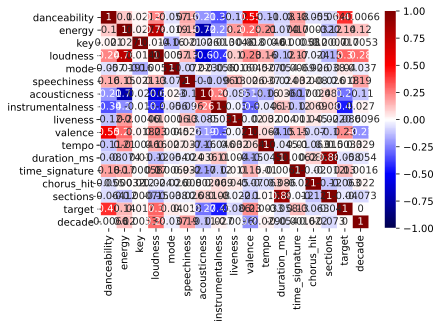

In [5]:
sns.heatmap(songs_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [6]:
X = songs_df.drop(columns=['target','uri','artist','track','decade'])
y = songs_df['target'].values

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [9]:
def get_metrics(X,y,X_val,y_val,model,name): 
    model = model.fit(X,y)
    y_pred = model.predict(X_val)
    print('{} train score: {:.3f}'.format(name,model.score(X,y)))
    print('{} test score: {:.3f}'.format( name, model.score(X_val,y_val)))
    print(classification_report(y_val, y_pred))
    fig, ax = plt.subplots(figsize=(7, 7))
    print(plot_confusion_matrix(model, X_val, y_val, ax=ax))
    return model

In [86]:
def voting_classifier(model_list,voting):
    voting_classifier= VotingClassifier(estimators=model_list,
                                    voting=voting, #<-- sklearn calls this hard voting
                                    n_jobs=-1)
    voting_classifier.fit(X_train_scaled, y_train)
    y_pred = voting_classifier.predict(X_val_scaled)
    y_pred_test 
    print(accuracy_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    fig, ax = plt.subplots(figsize=(7, 7))
    print(plot_confusion_matrix(voting_classifier, X_val_scaled, y_val, ax=ax,cmap=plt.cm.Greens))
    return voting_classifier

kNN train score: 0.811
kNN test score: 0.779
              precision    recall  f1-score   support

           0       0.85      0.68      0.76      2983
           1       0.73      0.88      0.80      2945

    accuracy                           0.78      5928
   macro avg       0.79      0.78      0.78      5928
weighted avg       0.79      0.78      0.78      5928



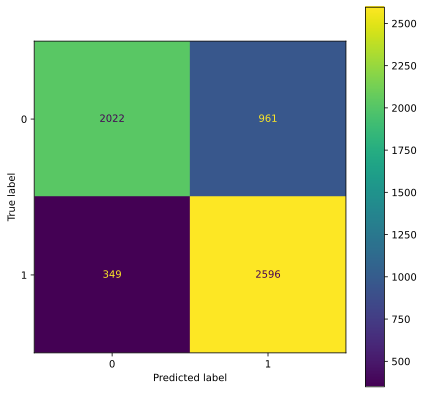

In [43]:
knn = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,KNeighborsClassifier(n_neighbors=14,n_jobs=-1),'kNN')

lr train score: 0.779
lr test score: 0.774
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      2983
           1       0.74      0.84      0.79      2945

    accuracy                           0.77      5928
   macro avg       0.78      0.77      0.77      5928
weighted avg       0.78      0.77      0.77      5928



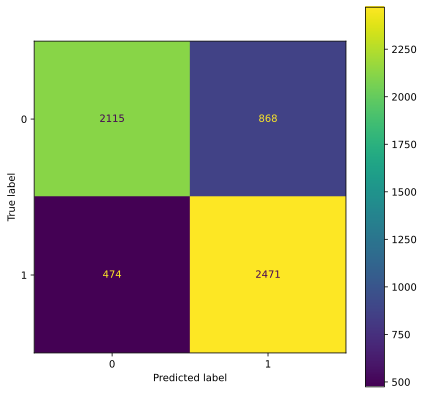

In [44]:
lr = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,LogisticRegression(penalty='none'),'lr')

svc train score: 0.828
svc test score: 0.810
              precision    recall  f1-score   support

           0       0.87      0.73      0.80      2983
           1       0.77      0.89      0.82      2945

    accuracy                           0.81      5928
   macro avg       0.82      0.81      0.81      5928
weighted avg       0.82      0.81      0.81      5928



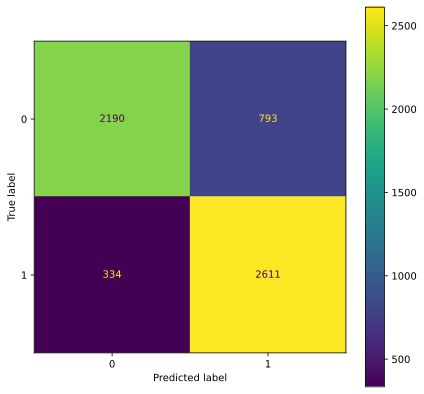

In [45]:
svc = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,SVC(probability=True),'svc')

nb train score: 0.743
nb test score: 0.733
              precision    recall  f1-score   support

           0       0.84      0.58      0.69      2983
           1       0.68      0.89      0.77      2945

    accuracy                           0.73      5928
   macro avg       0.76      0.73      0.73      5928
weighted avg       0.76      0.73      0.73      5928



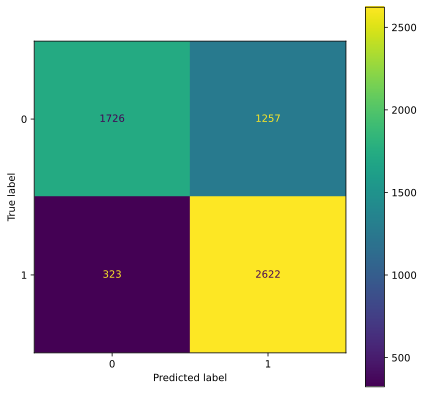

In [46]:
nb = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,GaussianNB(),'nb')

dt train score: 0.999
dt test score: 0.741
              precision    recall  f1-score   support

           0       0.74      0.75      0.75      2983
           1       0.75      0.73      0.74      2945

    accuracy                           0.74      5928
   macro avg       0.74      0.74      0.74      5928
weighted avg       0.74      0.74      0.74      5928



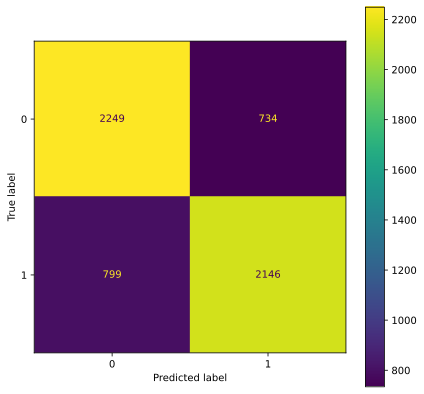

In [47]:
dt = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,DecisionTreeClassifier(random_state=0),'dt')

#### Decision Tree Grid Search

In [10]:
param_grid = {
    'max_depth': range(0,11),
    'min_samples_leaf': range(0,101),
}
dt =DecisionTreeClassifier()


grid_search = GridSearchCV(estimator = dt, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_scaled, y_train)

grid_search.best_params_

Fitting 3 folds for each of 1111 candidates, totalling 3333 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1547 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2260 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3318 out of 3333 | elapsed:   27.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3333 out of 3333 | elapsed:   28.0s finished


{'max_depth': 8, 'min_samples_leaf': 56}

dt train score: 0.812
dt test score: 0.787
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      2966
           1       0.76      0.83      0.80      2962

    accuracy                           0.79      5928
   macro avg       0.79      0.79      0.79      5928
weighted avg       0.79      0.79      0.79      5928



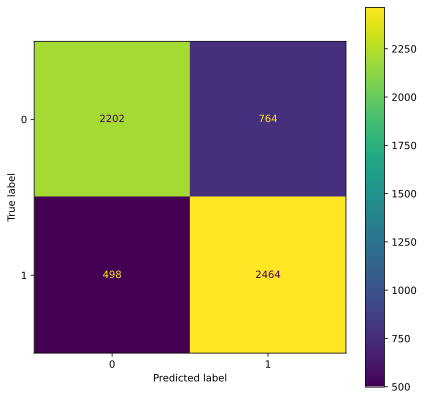

In [40]:
dt = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,DecisionTreeClassifier(max_depth=8,min_samples_leaf=56),'dt')

rf train score: 0.999
rf test score: 0.816
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      2966
           1       0.79      0.86      0.82      2962

    accuracy                           0.82      5928
   macro avg       0.82      0.82      0.82      5928
weighted avg       0.82      0.82      0.82      5928



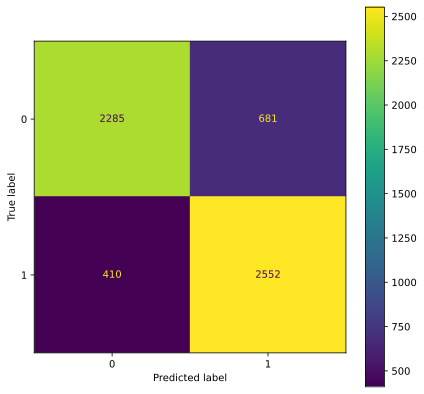

In [41]:
rf = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,RandomForestClassifier(random_state=0),'rf')

In [42]:
param_grid = {
    'max_depth': range(0,100),
    'min_samples_leaf': range(0,11),
}
rf = RandomForestClassifier()


grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_scaled, y_train)

grid_search.best_params_

Fitting 3 folds for each of 1100 candidates, totalling 3300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1029 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1474 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 2001 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 2608 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 3300 out of 3300 | elapsed: 16.2min finished


{'max_depth': 99, 'min_samples_leaf': 2}

rf train score: 0.886
rf test score: 0.813
              precision    recall  f1-score   support

           0       0.85      0.77      0.80      2966
           1       0.79      0.86      0.82      2962

    accuracy                           0.81      5928
   macro avg       0.82      0.81      0.81      5928
weighted avg       0.82      0.81      0.81      5928



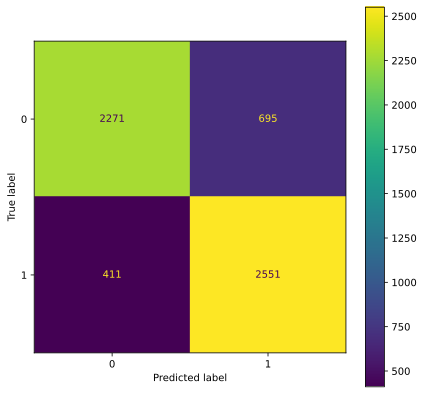

In [45]:
rf = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,RandomForestClassifier(max_depth=99,min_samples_leaf=8),'rf')

* plot feature importance for random classifier

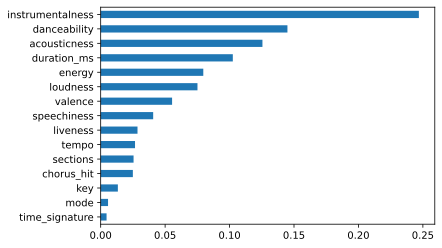

In [52]:
(pd.Series(rf.feature_importances_, index=X.columns)
   .nlargest(16)
   .plot(kind='barh')).invert_yaxis()

In [56]:
model_names = ["lr","nb","knn", "svc", "rf"]

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [57]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_val_scaled, y_val)}')

lr score: 0.7736167341430499
nb score: 0.733468286099865
knn score: 0.7790148448043185
svc score: 0.809885290148448
rf score: 0.8114035087719298


### Voting classifier w/ 'hard' voting

0.8021255060728745
              precision    recall  f1-score   support

           0       0.87      0.71      0.78      2983
           1       0.75      0.89      0.82      2945

    accuracy                           0.80      5928
   macro avg       0.81      0.80      0.80      5928
weighted avg       0.81      0.80      0.80      5928



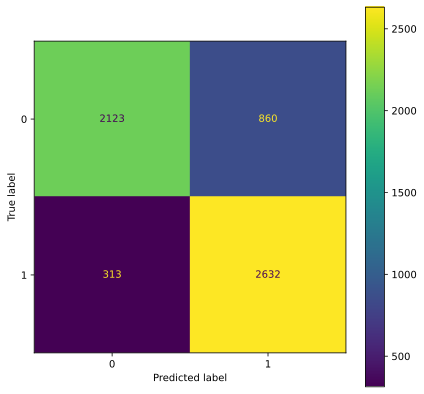

In [71]:
decision_voting = voting_classifier(model_list,'hard')

### Voting classifier w/ 'soft' voting

In [69]:
def voting_classifier(model_list,voting):
    voting_classifier= VotingClassifier(estimators=model_list,
                                    voting=voting, #<-- sklearn calls this hard voting
                                    n_jobs=-1)
    voting_classifier.fit(X_train_scaled, y_train)
    y_pred = voting_classifier.predict(X_val_scaled)
    print(accuracy_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    fig, ax = plt.subplots(figsize=(7, 7))
    print(plot_confusion_matrix(voting_classifier, X_val_scaled, y_val, ax=ax))
    return voting_classifier

0.7955465587044535
              precision    recall  f1-score   support

           0       0.88      0.69      0.77      2983
           1       0.74      0.90      0.81      2945

    accuracy                           0.80      5928
   macro avg       0.81      0.80      0.79      5928
weighted avg       0.81      0.80      0.79      5928



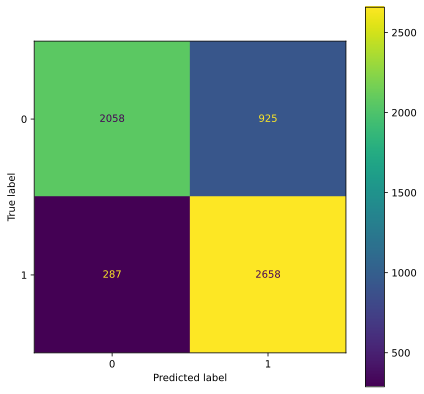

In [70]:
avg_voting = voting_classifier(model_list,'soft')

## Plot ROC

In [74]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val, knn.predict_proba(X_val_scaled)[:,1])
fpr_log, tpr_log, thresholds_log = roc_curve(y_val, lr.predict_proba(X_val_scaled)[:,1])
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_val, nb.predict_proba(X_val_scaled)[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, rf.predict_proba(X_val)[:,1])
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_val, svc.predict_proba(X_val_scaled)[:,1])
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_val, dt.predict_proba(X_val)[:,1])
fpr_vc,tpr_vc,thresholds_vc = roc_curve(y_val, avg_voting.predict_proba(X_val_scaled)[:,1])

KNN ROC AUC score =  0.8458224221351667
Logit ROC AUC score =  0.8361514911607201
Naive Bayes ROC AUC score =  0.8263409461766079
Random Forest ROC AUC score =  0.8834352786901669
Support Vector Machines ROC AUC score =  0.8777815089127012
Decision Tree ROC AUC score =  0.7414438467672213
Voting Classifier ROC AUC score =  0.873136056214417


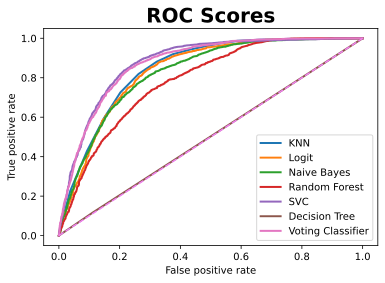

In [76]:
plt.plot(fpr_knn, tpr_knn,lw=2)
plt.plot(fpr_log, tpr_log,lw=2)
plt.plot(fpr_nb, tpr_nb,lw=2)
plt.plot(fpr_rf, tpr_rf,lw=2)
plt.plot(fpr_svc, tpr_svc,lw=2)
plt.plot(fpr_dt, tpr_dt,lw=2)
plt.plot(fpr_vc, tpr_vc,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Scores', fontweight='bold', fontsize=20);
plt.legend(['KNN', 'Logit', 'Naive Bayes', 'Random Forest','SVC', 'Decision Tree','Voting Classifier'])
print('KNN ROC AUC score = ', roc_auc_score(y_val, knn.predict_proba(X_val_scaled)[:,1]))
print('Logit ROC AUC score = ', roc_auc_score(y_val, lr.predict_proba(X_val_scaled)[:,1]))
print('Naive Bayes ROC AUC score = ', roc_auc_score(y_val, nb.predict_proba(X_val_scaled)[:,1]))
print('Random Forest ROC AUC score = ', roc_auc_score(y_val, rf.predict_proba(X_val_scaled)[:,1]))
print('Support Vector Machines ROC AUC score = ', roc_auc_score(y_val, svc.predict_proba(X_val_scaled)[:,1]))
print('Decision Tree ROC AUC score = ', roc_auc_score(y_val, dt.predict_proba(X_val_scaled)[:,1]))
print('Voting Classifier ROC AUC score = ', roc_auc_score(y_val, avg_voting.predict_proba(X_val_scaled)[:,1]))

## Try Models with Top 100 Artist by Value Counts

* **First I'm gonna plot the top 10 artist and there hit/flop counts**

In [90]:
top_twenty = songs_df['artist'].value_counts().iloc[:21]
mask = songs_df['artist'].isin(top_twenty.index)

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


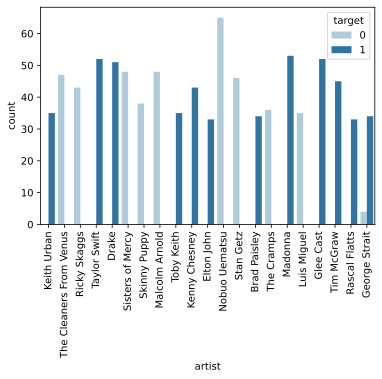

In [98]:
sns.countplot(songs_df['artist'][mask],hue=songs_df['target'],palette="Paired");
plt.xticks(rotation=90);
plt.savefig('artist.png')

In [73]:
top_hundred = songs_df['artist'].value_counts().iloc[:101]
mask = songs_df['artist'].isin(top_hundred.index)

In [74]:
songs_df = pd.concat([songs_df, artist_dummies], axis=1)


In [75]:
songs_df.shape

(24698, 121)

In [76]:
X = songs_df.drop(columns=['target','uri','track','artist','decade'])
y = songs_df['target'].values

In [77]:
X.fillna(0,inplace=True)

In [78]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3)

In [79]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

# scaledfile = 'finalized_scale.sav'
# pickle.dump(scaler, open(scaledfile, 'wb'))

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

kNN train score: 0.825
kNN test score: 0.806
              precision    recall  f1-score   support

           0       0.87      0.72      0.79      2969
           1       0.76      0.90      0.82      2959

    accuracy                           0.81      5928
   macro avg       0.82      0.81      0.80      5928
weighted avg       0.82      0.81      0.80      5928



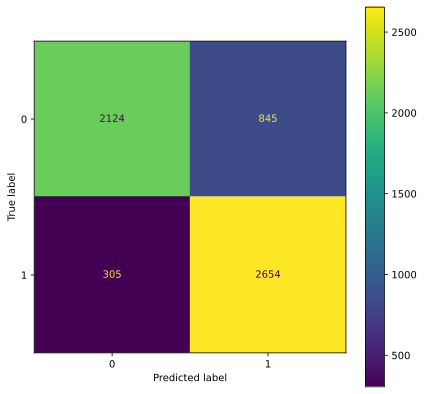

In [21]:
knn = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,KNeighborsClassifier(n_neighbors=14,n_jobs=-1),'kNN')

lr train score: 0.800
lr test score: 0.796
              precision    recall  f1-score   support

           0       0.83      0.74      0.79      2969
           1       0.77      0.85      0.81      2959

    accuracy                           0.80      5928
   macro avg       0.80      0.80      0.80      5928
weighted avg       0.80      0.80      0.80      5928



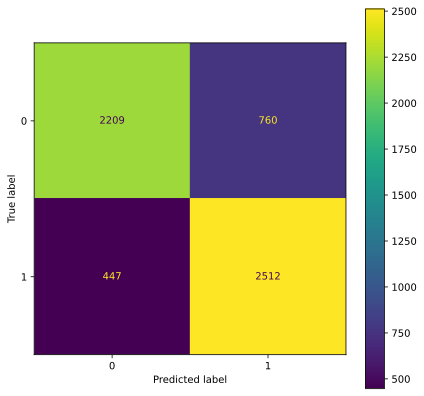

In [22]:
lr = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,LogisticRegression(penalty='none'),'lr')

svc train score: 0.820
svc test score: 0.821
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      2969
           1       0.77      0.92      0.84      2959

    accuracy                           0.82      5928
   macro avg       0.83      0.82      0.82      5928
weighted avg       0.83      0.82      0.82      5928



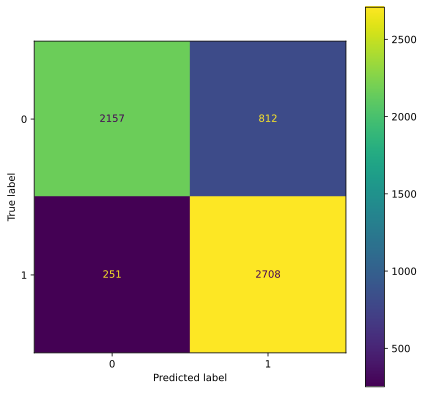

In [23]:
svc = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,SVC(probability=True),'svc')

nb train score: 0.564
nb test score: 0.561
              precision    recall  f1-score   support

           0       0.53      1.00      0.70      2969
           1       0.99      0.12      0.22      2959

    accuracy                           0.56      5928
   macro avg       0.76      0.56      0.46      5928
weighted avg       0.76      0.56      0.46      5928



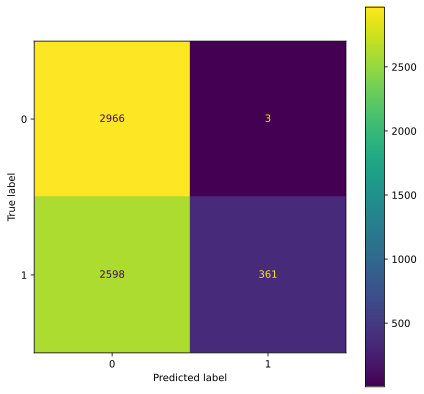

In [24]:
nb = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,GaussianNB(),'nb')

dt train score: 1.000
dt test score: 0.750
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      2969
           1       0.75      0.75      0.75      2959

    accuracy                           0.75      5928
   macro avg       0.75      0.75      0.75      5928
weighted avg       0.75      0.75      0.75      5928



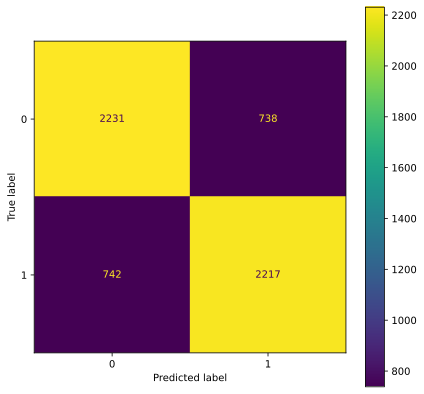

In [25]:
dt = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,DecisionTreeClassifier(random_state=0),'dt')

In [26]:
param_grid = {
    'max_depth': range(0,100),
    'min_samples_leaf': range(0,11),
}
rf = RandomForestClassifier()


grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_scaled, y_train)

grid_search.best_params_

Fitting 3 folds for each of 1100 candidates, totalling 3300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 3300 out of 3300 | elapsed: 15.5min finished


{'max_depth': 44, 'min_samples_leaf': 1}

rf train score: 0.831
rf test score: 0.809
              precision    recall  f1-score   support

           0       0.85      0.75      0.80      2979
           1       0.77      0.87      0.82      2949

    accuracy                           0.81      5928
   macro avg       0.81      0.81      0.81      5928
weighted avg       0.81      0.81      0.81      5928



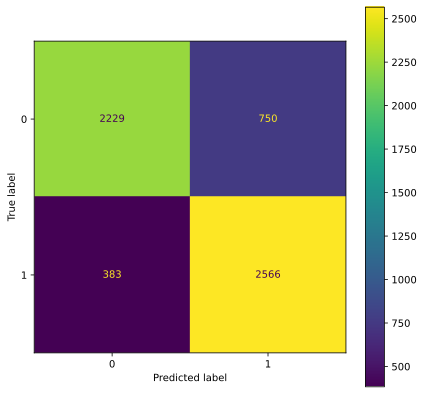

In [81]:
rf = get_metrics(X_train_scaled,y_train,X_val_scaled,y_val,RandomForestClassifier(random_state=0,max_depth=44,min_samples_leaf=8),'rf')

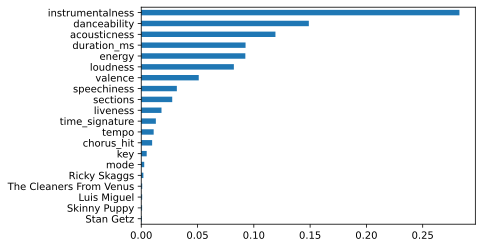

In [82]:
(pd.Series(rf.feature_importances_, index=X.columns)
   .nlargest(20)
   .plot(kind='barh')).invert_yaxis()

In [83]:
model_names = ["lr","nb","knn", "svc", "rf"]

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [84]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_val_scaled, y_val)}')

lr score: 0.7947031039136302
nb score: 0.5506072874493927
knn score: 0.8105600539811066
svc score: 0.8156207827260459
rf score: 0.8088731443994602


0.8259109311740891
              precision    recall  f1-score   support

           0       0.87      0.77      0.81      2969
           1       0.79      0.89      0.84      2959

    accuracy                           0.83      5928
   macro avg       0.83      0.83      0.83      5928
weighted avg       0.83      0.83      0.83      5928



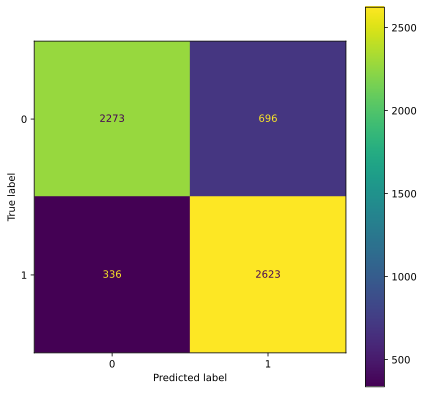

In [31]:
decision_voting = voting_classifier(model_list,'hard')

0.8137651821862348
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      2979
           1       0.82      0.81      0.81      2949

    accuracy                           0.81      5928
   macro avg       0.81      0.81      0.81      5928
weighted avg       0.81      0.81      0.81      5928



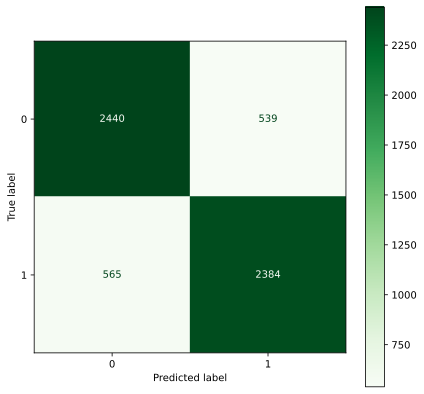

In [87]:
avg_voting = voting_classifier(model_list,'soft')

## XGBoost

In [35]:
gbm = xgb.XGBClassifier( 
                        n_estimators=10000,
                        max_depth=4,
                        objective='binary:logistic', 
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', 
                    early_stopping_rounds=50,
                    verbose=False
                   )
print(accuracy_score(y_train, gbm.predict(X_train, ntree_limit=gbm.best_ntree_limit)))
print(accuracy_score(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)))
print(classification_report(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)))

0.8650759219088937
0.828778677462888
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      2969
           1       0.80      0.88      0.84      2959

    accuracy                           0.83      5928
   macro avg       0.83      0.83      0.83      5928
weighted avg       0.83      0.83      0.83      5928



## Plot ROC

In [36]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val, knn.predict_proba(X_val_scaled)[:,1])
fpr_log, tpr_log, thresholds_log = roc_curve(y_val, lr.predict_proba(X_val_scaled)[:,1])
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_val, nb.predict_proba(X_val_scaled)[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, rf.predict_proba(X_val)[:,1])
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_val, svc.predict_proba(X_val_scaled)[:,1])
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_val, dt.predict_proba(X_val)[:,1])
fpr_vc,tpr_vc,thresholds_vc = roc_curve(y_val, avg_voting.predict_proba(X_val_scaled)[:,1])
fpr_gbm,tpr_gbm,thresholds_gbm = roc_curve(y_val, gbm.predict_proba(X_val)[:,1])

KNN ROC AUC score =  0.879950089189053
Logit ROC AUC score =  0.8754770911449402
Naive Bayes ROC AUC score =  0.8650334178649697
Random Forest ROC AUC score =  0.8783117219719233
Support Vector Machines ROC AUC score =  0.8869610852072748
Decision Tree ROC AUC score =  0.7504625070757636
Voting Classifier ROC AUC score =  0.9011104495239818


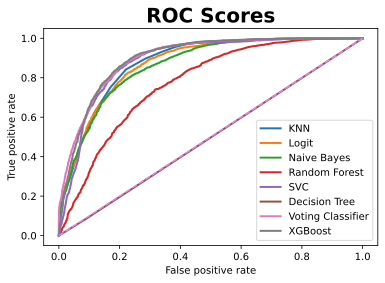

In [37]:
plt.plot(fpr_knn, tpr_knn,lw=2)
plt.plot(fpr_log, tpr_log,lw=2)
plt.plot(fpr_nb, tpr_nb,lw=2)
plt.plot(fpr_rf, tpr_rf,lw=2)
plt.plot(fpr_svc, tpr_svc,lw=2)
plt.plot(fpr_dt, tpr_dt,lw=2)
plt.plot(fpr_vc, tpr_vc,lw=2)
plt.plot(fpr_gbm, tpr_gbm,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Scores', fontweight='bold', fontsize=20);
plt.legend(['KNN', 'Logit', 'Naive Bayes', 'Random Forest','SVC', 'Decision Tree','Voting Classifier','XGBoost'])
print('KNN ROC AUC score = ', roc_auc_score(y_val, knn.predict_proba(X_val_scaled)[:,1]))
print('Logit ROC AUC score = ', roc_auc_score(y_val, lr.predict_proba(X_val_scaled)[:,1]))
print('Naive Bayes ROC AUC score = ', roc_auc_score(y_val, nb.predict_proba(X_val_scaled)[:,1]))
print('Random Forest ROC AUC score = ', roc_auc_score(y_val, rf.predict_proba(X_val_scaled)[:,1]))
print('Support Vector Machines ROC AUC score = ', roc_auc_score(y_val, svc.predict_proba(X_val_scaled)[:,1]))
print('Decision Tree ROC AUC score = ', roc_auc_score(y_val, dt.predict_proba(X_val_scaled)[:,1]))
print('Voting Classifier ROC AUC score = ', roc_auc_score(y_val, avg_voting.predict_proba(X_val_scaled)[:,1]))
#print('XgBoost ROC AUC score = ', roc_auc_score(y_val, gbm.predict_proba(X_val)[:,1]))

In [88]:
len(songs_df['artist'].unique())

9453

#### Top models in consideration
* Voting Classifier w/ soft voting
* XGBoost 
* Random Forest

* XGBoost gave me the best overall score of 0.829 and an ROC of 0.892
* Voting classifier has a lower score at 0.813 and an ROC-AUC of 0.892 but it has better recall than XGBoost when it comes to predicting if a 'Flop' is really a 'Flop'
* Random Forest gave me a good score of 0.816 and an ROC AUC of 0.885 I can also verify feature importance using Random Forest and it run my models relatively fast but its recall for flops is 0.76 which mean nearly 25% of flops are being classified as hits as compared to the voting classifier

In [38]:
y_pred = avg_voting.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.808502024291498

In [ ]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val, knn.predict_proba(X_val_scaled)[:,1])
fpr_log, tpr_log, thresholds_log = roc_curve(y_val, lr.predict_proba(X_val_scaled)[:,1])
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_val, nb.predict_proba(X_val_scaled)[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, rf.predict_proba(X_val)[:,1])
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_val, svc.predict_proba(X_val_scaled)[:,1])
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_val, dt.predict_proba(X_val)[:,1])
fpr_vc,tpr_vc,thresholds_vc = roc_curve(y_val, avg_voting.predict_proba(X_val_scaled)[:,1])
fpr_gbm,tpr_gbm,thresholds_gbm = roc_curve(y_val, gbm.predict_proba(X_val)[:,1])

In [39]:
# filename = 'finalized_model.sav'
# pickle.dump(avg_voting, open(filename, 'wb'))